In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=0.8)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# **Load**

In [3]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [4]:
Real = pd.read_csv("/content/drive/MyDrive/NLP_course_AF/true.csv")
Real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
FAKE_CLASS = 1
REAL_CLASS = 0

In [6]:
Real['Class'] = REAL_CLASS

In [7]:
Real.head()

,title,text,subject,date,Class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [8]:
Fake = pd.read_csv("/content/drive/MyDrive/NLP_course_AF/fake.csv")
Fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
Fake['Class'] = FAKE_CLASS
Fake.head()

,title,text,subject,date,Class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [10]:
Fake = Fake[:2000]
Real = Real[:2000]

# **Concatenate Two DataFrames**

In [12]:
# Concatenate the DataFrames along the rows (axis=0)
df = pd.concat([Real,Fake], ignore_index=True)
df.head()

,title,text,subject,date,Class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [13]:
df=df.dropna()

In [14]:
df.shape

(4000, 5)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4000 non-null   object
 1   text     4000 non-null   object
 2   subject  4000 non-null   object
 3   date     4000 non-null   object
 4   Class    4000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 156.4+ KB


In [16]:
df['Class'].value_counts()

Class
0    2000
1    2000
Name: count, dtype: int64

# **Model**

In [23]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [24]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [25]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [26]:
sample_txt = 'Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.'

In [27]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.
   Tokens: ['Trump', 'campaign', 'ad', '##viser', 'George', 'Papa', '##do', '##pou', '##los', 'told', 'an', 'Australian', 'diplomat', 'in', 'May', '2016', 'that', 'Russia', 'had', 'political', 'dir', '##t', 'on', 'Democratic', 'presidential', 'candidate', 'Hillary', 'Clinton', ',', 'the', 'New', 'York', 'Times', 'reported', 'on', 'Saturday', '.']
Token IDs: [29846, 17323, 10840, 54478, 10955, 17429, 10317, 73535, 13788, 21937, 10151, 12829, 45652, 10106, 10725, 10255, 10189, 14664, 10374, 13736, 15895, 10123, 10135, 19281, 36476, 22102, 72734, 24139, 117, 10105, 10287, 10482, 12020, 15943, 10135, 24848, 119]


In [28]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
token_lens = []

for txt in df.text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512,truncation=True)
      token_lens.append(len(tokens))

In [32]:
selected_columns = ['text', 'Class']
df = df[selected_columns]

In [33]:
MAX_LEN = 512

In [34]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [36]:
df_train.shape, df_val.shape, df_test.shape

((2800, 2), (600, 2), (600, 2))

In [37]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.text.to_numpy(),
    targets=df.Class.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [38]:
import warnings

# Ignore the specific FutureWarning related to truncation
warnings.filterwarnings("ignore", message="Truncation was not explicitly activated*")

In [39]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [42]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [43]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [44]:
class FakenewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FakenewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [45]:
model = FakenewsClassifier(2)
model = model.to(device)

In [46]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [47]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5023, 0.4977],
        [0.3489, 0.6511],
        [0.2759, 0.7241],
        [0.3333, 0.6667],
        [0.4317, 0.5683],
        [0.3950, 0.6050],
        [0.2982, 0.7018],
        [0.4291, 0.5709]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# ***Training***

In [48]:
EPOCHS = 5
LOAD_WEGHITS = False

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [49]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:
# Add your evaluation function here
def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
import warnings

# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")


In [53]:
best_model_path = "/content/drive/MyDrive/NLP_course_AF/BERTbest_model_state.bin"

In [54]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from collections import defaultdict

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    return model

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

# Initialize history and best_accuracy
history = defaultdict(list)
best_accuracy = 0

if not LOAD_WEGHITS:
    # Training loop
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save the best model
        if val_acc > best_accuracy:
            save_model(model, best_model_path)
            best_accuracy = val_acc
            print(f"Best model saved with accuracy {best_accuracy}")

    print(f"Training complete. Best accuracy: {best_accuracy}")

else:
    # Loading the best model (if needed later)
    model = load_model(model, best_model_path)
    model = model.to(device)

Epoch 1/5
----------


Training: 100%|██████████| 350/350 [04:30<00:00,  1.30batch/s, loss=0.0458]


Train loss 0.045783869594639065 accuracy 0.9871428571428571


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.26batch/s, loss=6.56e-5]


Val   loss 6.559942252351903e-05 accuracy 1.0

Best model saved with accuracy 1.0
Epoch 2/5
----------


Training: 100%|██████████| 350/350 [04:31<00:00,  1.29batch/s, loss=0.00657]


Train loss 0.00657329249182242 accuracy 0.9992857142857143


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.26batch/s, loss=0.000944]


Val   loss 0.0009441306590936923 accuracy 1.0

Epoch 3/5
----------


Training: 100%|██████████| 350/350 [04:32<00:00,  1.29batch/s, loss=0.00747]


Train loss 0.0074682310303874795 accuracy 0.9982142857142857


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.32batch/s, loss=0.000868]


Val   loss 0.0008681807761846963 accuracy 1.0

Epoch 4/5
----------


Training: 100%|██████████| 350/350 [04:32<00:00,  1.28batch/s, loss=3.06e-5]


Train loss 3.0623342957239534e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.36batch/s, loss=0.000747]


Val   loss 0.0007469723062483051 accuracy 1.0

Epoch 5/5
----------


Training: 100%|██████████| 350/350 [04:31<00:00,  1.29batch/s, loss=2.46e-5]


Train loss 2.4551024861076647e-05 accuracy 1.0


Evaluating: 100%|██████████| 75/75 [00:17<00:00,  4.25batch/s, loss=0.000681]

Val   loss 0.0006812417488739205 accuracy 1.0

Training complete. Best accuracy: 1.0


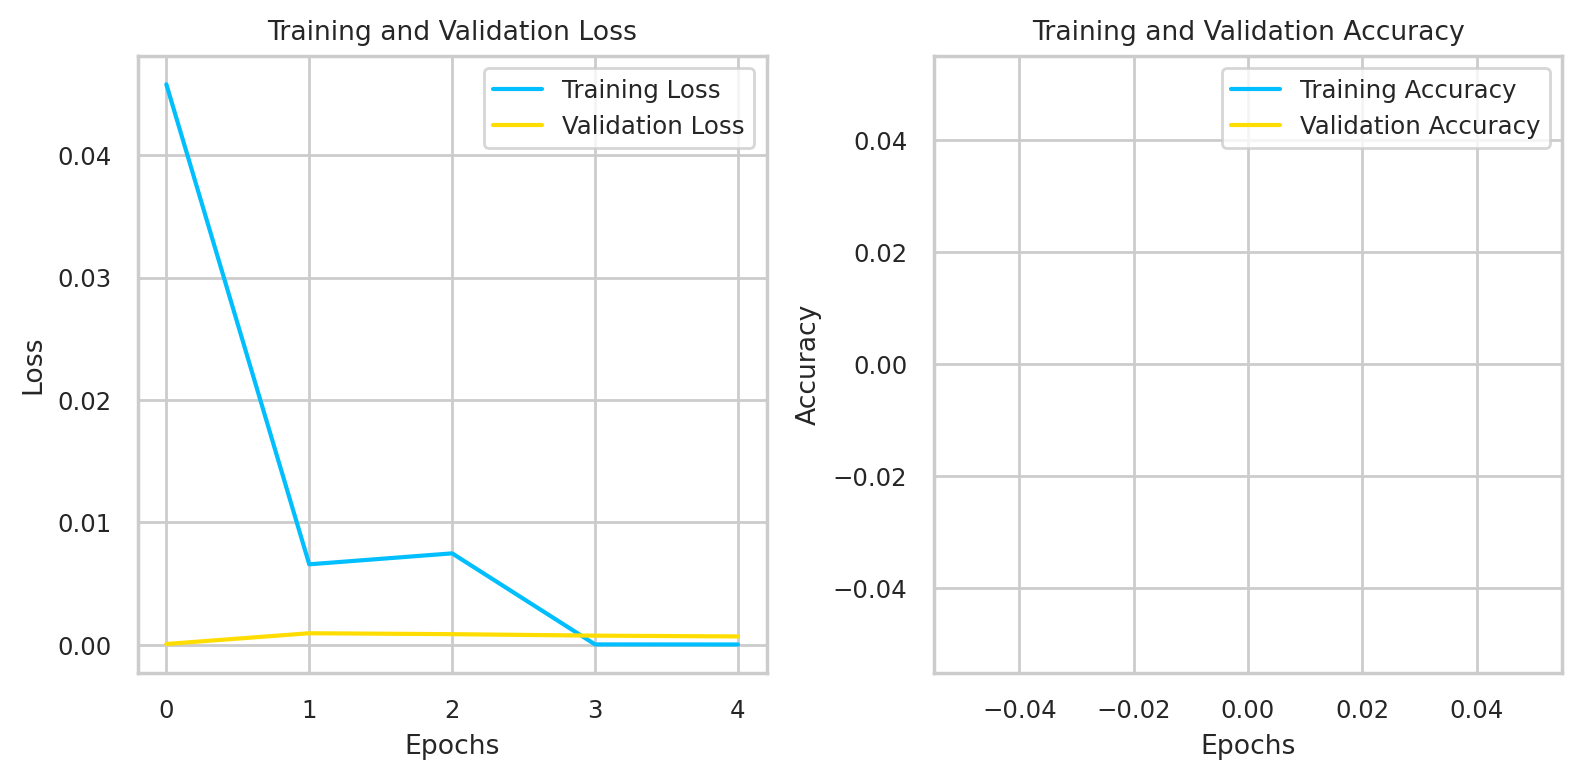

In [85]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Evaluation**

In [58]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 75/75 [00:18<00:00,  4.08batch/s, loss=0.000663]


1.0

In [59]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [60]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# **Classification report**

In [61]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

        Real     1.0000    1.0000    1.0000       319
        Fake     1.0000    1.0000    1.0000       281

    accuracy                         1.0000       600
   macro avg     1.0000    1.0000    1.0000       600
weighted avg     1.0000    1.0000    1.0000       600



# **Confusion Matrix**

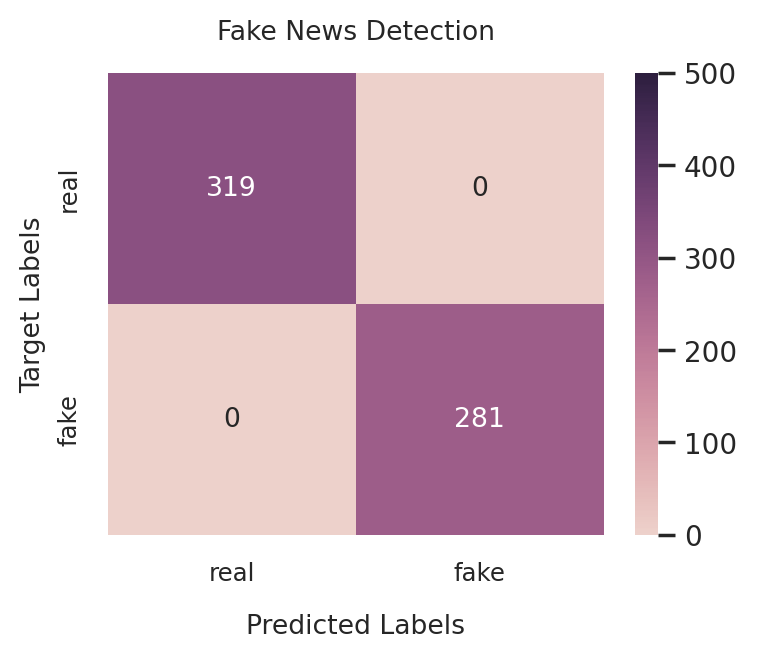

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)



# Plot confusion matrix
plt.figure(figsize=(4, 3))
# Define the custom palette
custom_palette = sns.cubehelix_palette( as_cmap=True)
# Define custom font dictionary for title and labels


# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['real', 'fake'], yticklabels=['real', 'fake'],vmin=0,vmax=500,)

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels')
heatmap.set_ylabel('Target Labels')
heatmap.set_title('Fake News Detection', pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.set_yticklabels(heatmap.get_yticklabels())

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()

# **Predicting on LLM**

In [76]:
def get_predictions_for_new_dataset(address="/content/drive/MyDrive/NLP_course_AF/LLM_generated_news/gpt_gen.csv", model=model, device=device, loss_fn=loss_fn, tokenizer=tokenizer):
    ds_fd = pd.read_csv(address)
    ds_fd['Class'] = FAKE_CLASS

    token_lens_new = []

    for txt in ds_fd.text:
      #tokenizing the text
          tokens_new = tokenizer.encode(txt, max_length=512,truncation=True)
          token_lens_new.append(len(tokens_new))

    new_data_loader = create_data_loader(ds_fd, tokenizer, MAX_LEN, BATCH_SIZE)


    new_acc, new_loss = eval_model(
      model,
      new_data_loader,
      loss_fn,
      device,
      len(ds_fd)
    )

    return new_acc.item(), new_loss/len(ds_fd), get_predictions(model, new_data_loader)

In [77]:
get_predictions_for_new_dataset()

Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.60batch/s, loss=4.87]


(0.4,
 0.12171719908714293,
 (["Mexico plans to review the necessity for tax changes following the reform in the United States, according to a document outlining the government's strategy. The review reflects Mexico's intention to assess the potential impact of U.S. tax reforms on its own fiscal policies. The document suggests a proactive approach to aligning Mexico's tax framework with changes in the global economic landscape. The review process underscores the importance of adapting to external developments to maintain competitiveness and stimulate economic growth. Mexico's commitment to evaluating tax policies demonstrates a willingness to adjust to evolving international dynamics while safeguarding its fiscal stability.",
   "On December 21, President Trump took to Twitter to highlight two significant topics: tax cuts and home sales. In his tweets, Trump likely praised the recent passage of the tax cuts bill, emphasizing its benefits for the American economy and taxpayers. Addition

In [78]:
get_predictions_for_new_dataset(address="/content/drive/MyDrive/NLP_course_AF/LLM_generated_news/claude_gen.csv")

Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.80batch/s, loss=2.13]


(0.75,
 0.06659169727936387,
 (["Former White House chief strategist Steve Bannon has been asked to testify before the House of Representatives intelligence committee as part of its investigation into alleged Russian interference in the 2016 U.S. presidential election, Bloomberg reported on Tuesday, citing a person familiar with the matter. The request suggests the committee's probe is entering a new phase after Republican committee members released a memo accusing the FBI of bias against President Donald Trump in its Russia investigation. Bannon had a fraught tenure at the White House before resigning in August and returning to the right-wing news website Breitbart News. He was quoted in a book accusing Trump of meeting with Russians during the campaign, which the president has denied.",
   "After securing a major legislative victory with the passage of a sweeping tax overhaul, Senate Majority Leader Mitch McConnell indicated he was more comfortable with President Donald Trump's proli